# The Heston Model

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In [1]:
#Package Import
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.optimize import brentq
from mpl_toolkits.mplot3d import Axes3D
sns.set_style('darkgrid')


%run functions_black_scholes.py


###Summary of Delta Hedging Sold Call Options

We looked into selling call options, assuming the distribution of stock paths follows a Geometric Brownian Motions, and the hedging with respect to the underlying stock until the expiration of the contract. There are two issues with this:

1) Geometric Brownian Motion assumes a static volatility.


2) It may be beneficial to sell or buy back an option before the expiration. It is therefore to understand the dynamics of not only the stock price, but the prices of option contracts in the market.

### Exploration

We will start by examining some historical option prices on the market and examine what the prices reflect.


One will quickly notice that market prices of options do not reflect prices that would be achieved by pricing according to the Black-Scholes equation.

**Recall**: The price of a stock option is a function of the stock's spot price, the strike price of the contract, and a constant volatility. 

If we examine the market prices of an option contract, the only unknown is the volatility.

**Implied Volatility** The implied volatility of an option contract with strike price $K$, time-to-expiration $t$, and premium $P$, is the $\sigma$ so that the Black-Scholes value of the option with volatility constant $\sigma$ is $P$. 

In [61]:
def implied_volatility_call(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    """
    Returns the implied volatility of a call option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    def objective(sigma):
        return bs_call(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan
    
def implied_volatility_put(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    """
    Returns the implied volatility of a put option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    def objective(sigma):
        return bs_put(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan



In [5]:
##Test implied volatility function

# Parameters
S0 = 550     
K = 545     
t = 1      
r = 0.035     
premium = 95.23

sigma = implied_volatility_call(premium, S0, K, t, r)
print(f"Implied Volatility of call options with market price ${premium}: {sigma}")


print('-----'*10)
print('-----'*10)

print(f'Black-Scholes price of call option with volatility {sigma}: ${bs_call(S0,K,sigma,t,r):.2f}')


Implied Volatility of call options with market price $95.23: 0.3882503230330192
--------------------------------------------------
--------------------------------------------------
Black-Scholes price of call option with volatility 0.3882503230330192: $95.23


In [7]:
### Some historical market price data 
### Source: https://www.kaggle.com/datasets/zeeshanfirdousi/optionsstocksdata?resource=download
### Remark: Accurate and reliable market prices of options are not free.
### There are numerous monthly subscription services with reliable API's that provide minute-by-minute historical
### market option prices.


options_data = pd.read_csv('Options_Stocks_Data.csv')
options_data

,Unnamed: 0,contractID,symbol,expiration,date,strike,type,last,mark,bid,ask,volume,open_interest,implied_volatility
0,1,IBM241025C00105000,IBM,2024-10-25,2024-10-25,105.0,call,112.54,109.67,108.55,110.80,0,3,4.09979
1,2,IBM241025P00105000,IBM,2024-10-25,2024-10-25,105.0,put,0.00,0.01,0.00,0.21,0,0,4.43832
2,3,IBM241025C00110000,IBM,2024-10-25,2024-10-25,110.0,call,0.00,105.15,103.75,106.55,0,0,6.46571
3,4,IBM241025P00110000,IBM,2024-10-25,2024-10-25,110.0,put,0.00,0.01,0.00,0.01,0,0,4.16470
4,5,IBM241025C00115000,IBM,2024-10-25,2024-10-25,115.0,call,0.00,99.82,98.85,100.80,0,0,5.09410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,1296,IBM270115P00320000,IBM,2027-01-15,2024-10-25,320.0,put,0.00,106.72,104.55,108.90,0,1,0.43827
1296,1297,IBM270115C00330000,IBM,2027-01-15,2024-10-25,330.0,call,6.25,5.62,5.30,5.95,0,297,0.20367
1297,1298,IBM270115P00330000,IBM,2027-01-15,2024-10-25,330.0,put,0.00,116.33,114.20,118.45,0,0,0.45839
1298,1299,IBM270115C00340000,IBM,2027-01-15,2024-10-25,340.0,call,5.35,4.47,3.70,5.25,3,204,0.20062


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


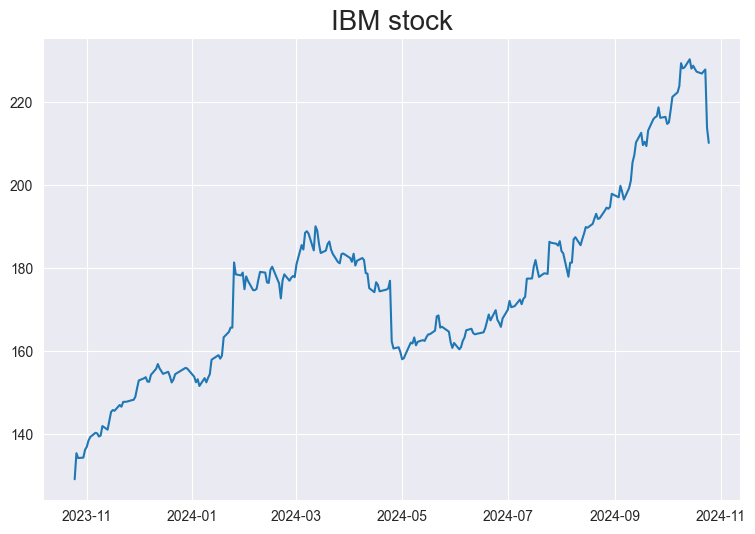

In [8]:
ibm_stock = yf.download('IBM', start = '2023-10-25', end = '2024-10-26')

plt.figure(figsize = (9,6))
plt.title('IBM stock', size = 20)

plt.plot(ibm_stock['Close'])


plt.show()

In [12]:
S0 = ibm_stock['Close'].iloc[-1].iloc[0]


sigma = np.log(ibm_stock['Close']/ibm_stock['Close'].shift(1)).std().iloc[0]*np.sqrt(252)
r = 0.035


start_date = datetime.datetime(2024,10,25,15,0)


print(f'Value of IBM stock on 10-25-2024: ${S0:.2f}')
print('----'*10)
print('----'*10)
print(f'Historical volatility of IBM stock: {sigma}')

Value of IBM stock on 10-25-2024: $210.18
----------------------------------------
----------------------------------------
Historical volatility of IBM stock: 0.22298699494268515


In [10]:
options_data_calls = options_data[(options_data['type']=='call')]
options_data_calls = options_data_calls[['expiration', 'strike', 'mark']]

In [11]:
options_data_calls.sample(5)

,expiration,strike,mark
258,2024-11-08,180.0,35.08
330,2024-11-15,115.0,100.05
1068,2025-06-20,330.0,0.42
912,2025-04-17,115.0,100.00
198,2024-11-01,250.0,0.01


In [13]:
def find_tte(expiration_date,start_date):
    '''returns time measured in years as a float between two dates
    
    Inputs:
    expiration_date (str): 'YYYY-MM-DD'
    current_date (datetime.datetime)
    
    Returns:
    Float of time to expiration in years
    '''
    ###Sets expiration time to 2:30 central = 3:30 eastern time = approx time when expiring options are settled
    tte = (datetime.datetime.strptime(expiration_date + '-2-30', '%Y-%m-%d-%H-%M')\
    - start_date).total_seconds()/(60*60*24*365)
    
    return tte

In [14]:
options_data_calls['time_to_expiration'] = options_data_calls['expiration'].apply(
    lambda x: find_tte(x, start_date)
)


options_data_calls['implied_volatility'] = options_data_calls.apply(
    lambda row: implied_volatility_call(
        market_price=row['mark'],
        S0=S0,
        K=row['strike'],
        t=row['time_to_expiration'],
        r=r
    ),
    axis=1
)

/Users/tmpolstra/Library/CloudStorage/Dropbox/2025_Erdös/11 Heston Model/functions_black_scholes.py:29: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
/Users/tmpolstra/Library/CloudStorage/Dropbox/2025_Erdös/11 Heston Model/functions_black_scholes.py:30: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma*np.sqrt(t)


In [15]:
options_data_calls

,expiration,strike,mark,time_to_expiration,implied_volatility
0,2024-10-25,105.0,109.67,-0.001427,NaN
2,2024-10-25,110.0,105.15,-0.001427,NaN
4,2024-10-25,115.0,99.82,-0.001427,NaN
6,2024-10-25,120.0,94.88,-0.001427,NaN
8,2024-10-25,125.0,90.15,-0.001427,NaN
...,...,...,...,...,...
1290,2027-01-15,300.0,8.57,2.223231,0.218863
1292,2027-01-15,310.0,7.20,2.223231,0.218391
1294,2027-01-15,320.0,5.95,2.223231,0.216929
1296,2027-01-15,330.0,5.62,2.223231,0.224824


In [33]:
options_data = pd.read_csv('Options_Stocks_Data.csv')

options_data_calls = options_data[(options_data['type']=='call')]
options_data_calls = options_data_calls[['expiration', 'strike', 'mark', 'volume']]


options_data_calls['time_to_expiration'] = options_data_calls['expiration'].apply(
    lambda x: find_tte(x, start_date)
)

options_data_calls = options_data_calls[(options_data_calls['time_to_expiration']>=1/12)\
                                       & (np.abs(options_data_calls['strike']-S0)/S0<=.2)\
                                       & (options_data_calls['time_to_expiration']<=1)]



options_data_calls['implied_volatility'] = options_data_calls.apply(
    lambda row: implied_volatility_call(
        market_price=row['mark'],
        S0=S0,
        K=row['strike'],
        t=row['time_to_expiration'],
        r=r
    ),
    axis=1
)


In [25]:
options_data_calls['volume'].values

array([   0,    0,    0,    0,    0,    0,    1,    2,   11,   16,   17,
         31,   26,   33,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,   12,   43,   38,   51,    8,    0,    1,    0,
          0,    0,    0,    0,    0,    2,    1,    9,    3,   20,  202,
       1257,  184,  217,  226,  178,  174,  207,   18,    1,    8,   19,
         36,   36,  153,   28,   32,  339,  200,  136,  206,  128,  222,
         28,  852,    0,    1,    6,    0,   11,   14,   32,   48,  133,
        123,  147,   44,    1,    0,    1,    0,    0,   15,   16,    1,
        134,   94,    4,   79,   46,   85,    1,   75,    6,    0,    0,
          0,    0,   73,    0,    7,   12,   40,   36,   54,  159,    0,
          2,   15,    0,    0,    0,    0,    0,    0,    1,    4,   11,
         23,    8,   18,    0,   51])

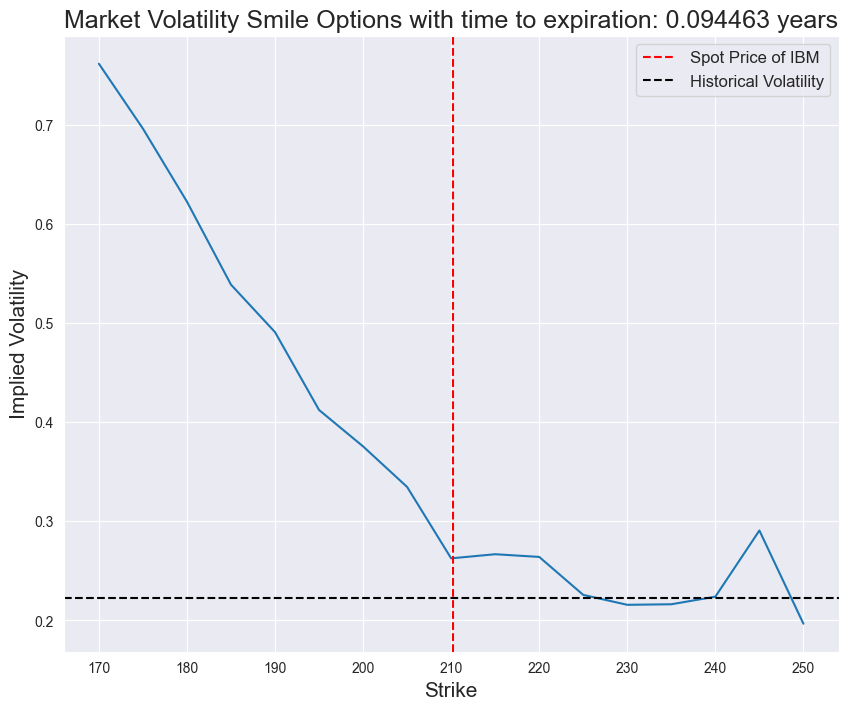

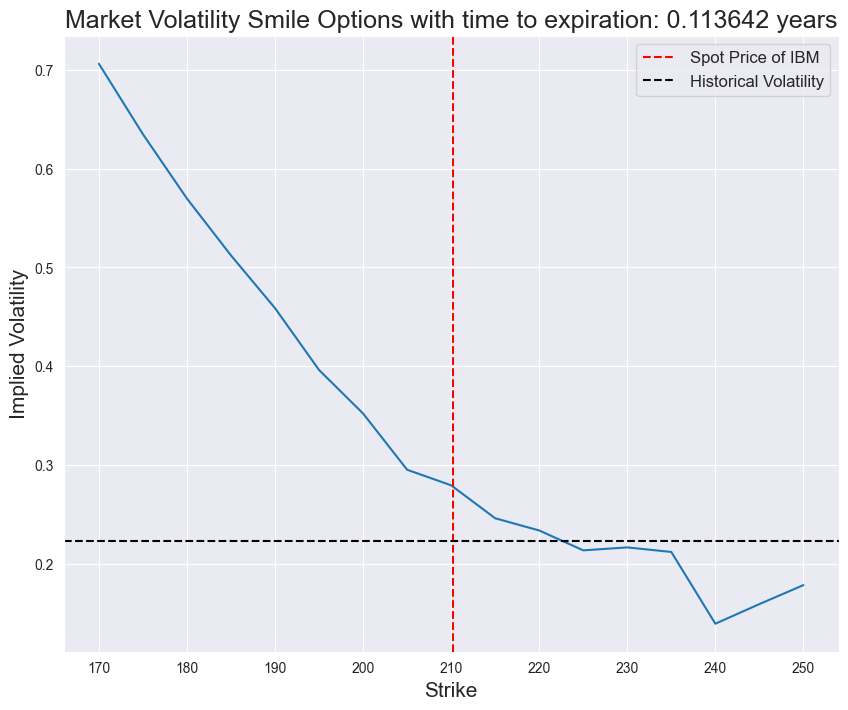

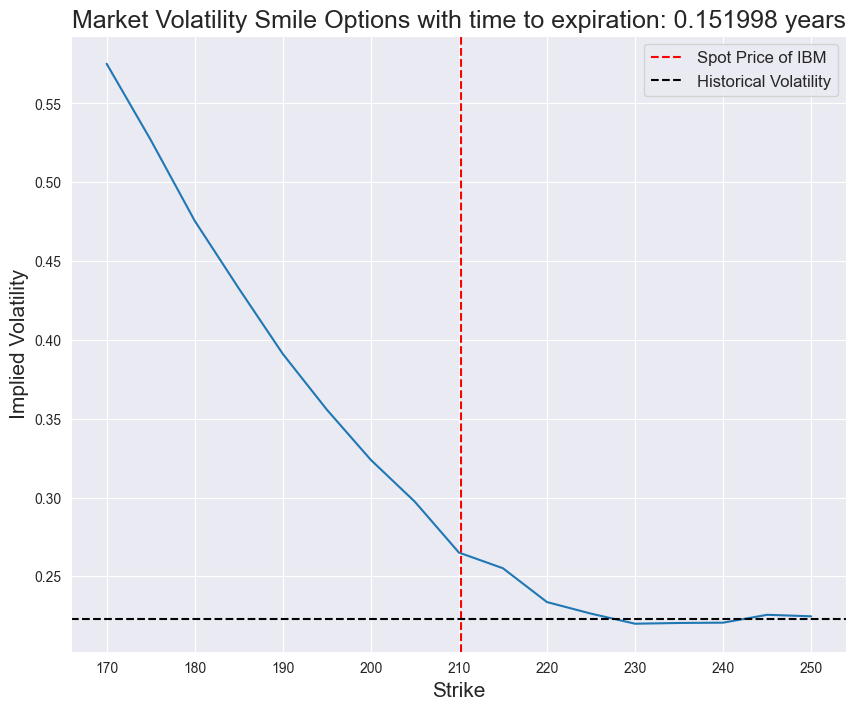

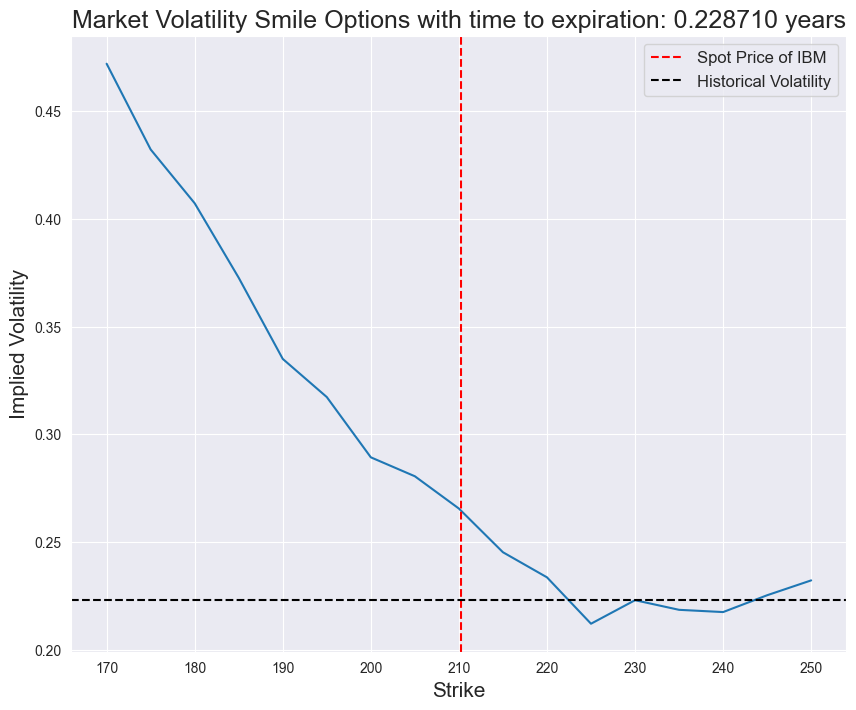

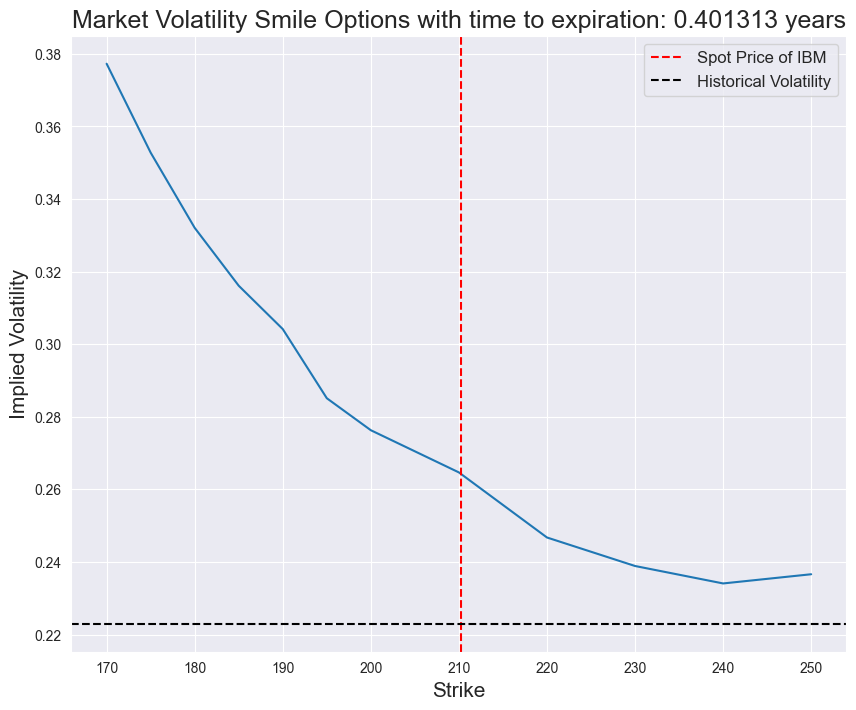

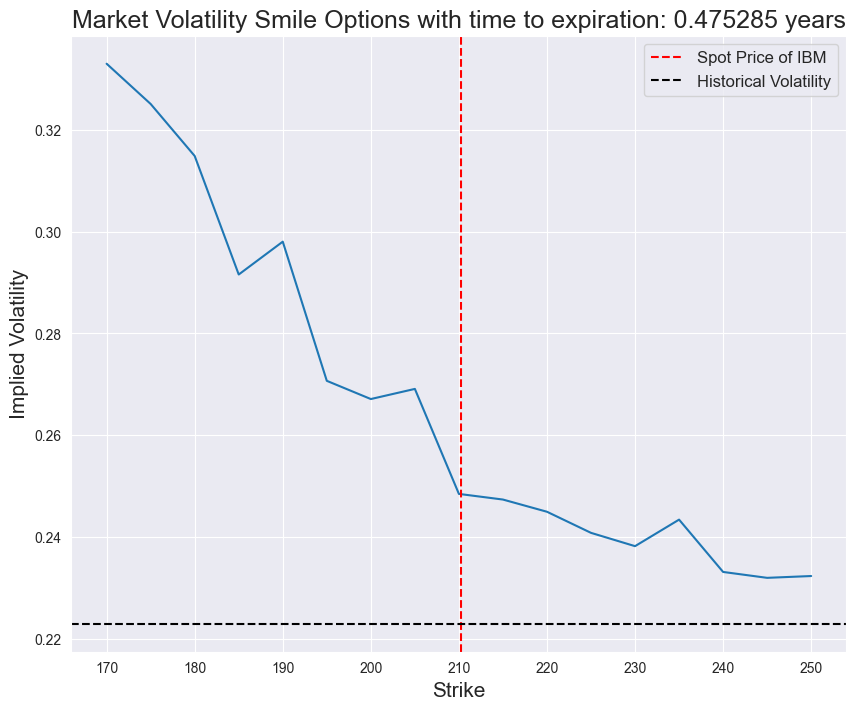

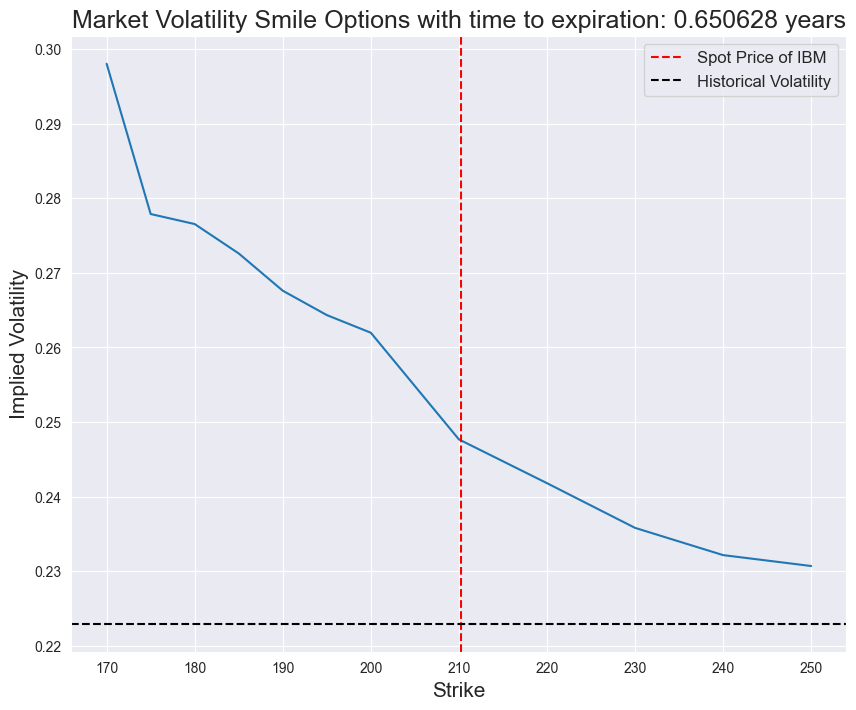

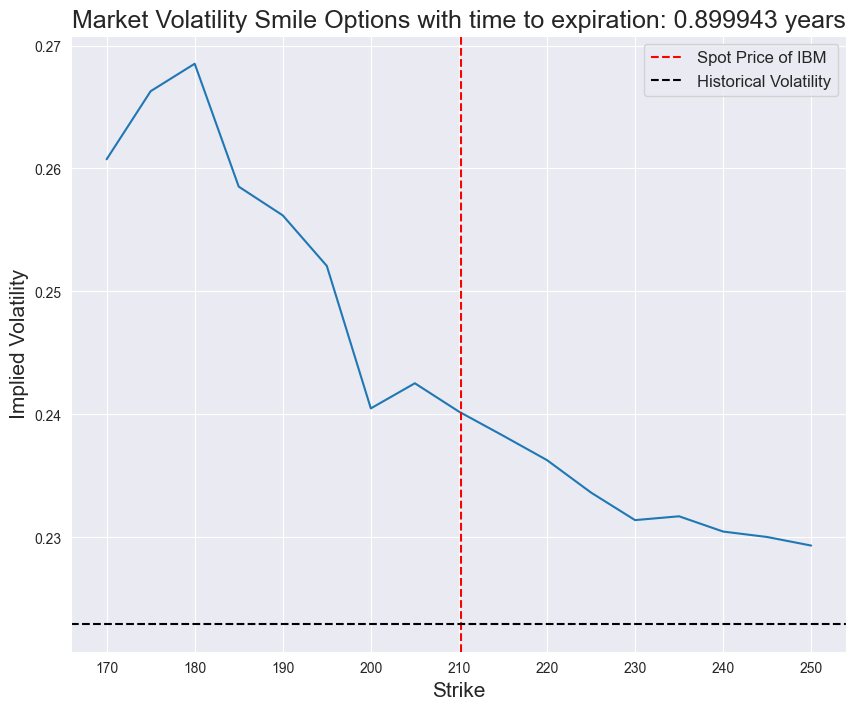

In [34]:
for date in np.unique(options_data_calls['expiration'].values):
    options_with_same_expiration =  options_data_calls[options_data_calls['expiration']==date].copy()
    tte = options_with_same_expiration['time_to_expiration'].iloc[0]
    plt.figure(figsize = (10,8))
    plt.plot(options_with_same_expiration['strike'], options_with_same_expiration['implied_volatility'])

    plt.title(f'Market Volatility Smile Options with time to expiration: {tte:4f} years', size = 18)

    plt.ylabel('Implied Volatility', size = 15)
    plt.xlabel('Strike', size = 15)

    plt.axvline(S0, label = 'Spot Price of IBM', ls = '--', color = 'red')

    plt.axhline(sigma, label = 'Historical Volatility', ls = '--', color = 'black')

    plt.legend(fontsize = 12)

    plt.show()

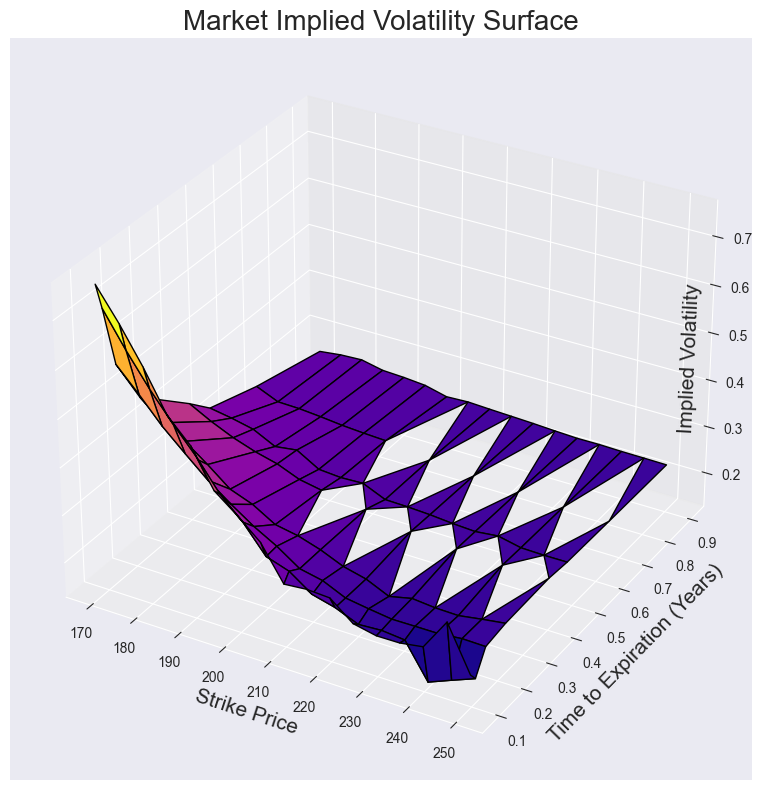

In [35]:
surface_df = options_data_calls.pivot_table(
    index='time_to_expiration', 
    columns='strike', 
    values='implied_volatility'
)



T, K = np.meshgrid(surface_df.index.values, surface_df.columns.values, indexing='ij')
IV = surface_df.values 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(K, T, IV, cmap='plasma', edgecolor='k')
ax.set_xlabel('Strike Price', fontsize = 15)
ax.set_ylabel('Time to Expiration (Years)', fontsize = 15)
ax.set_zlabel('Implied Volatility', fontsize=15, labelpad=-30)
ax.set_title('Market Implied Volatility Surface', size = 20)



plt.tight_layout()
plt.show()


## The Heston Model:

Benefits:

1) Allows for non-constant volatility and incorporates an autoregressive feature in volatility modeling.

    a) However, tuning a Heston model using stock-data to simulate stock path movements is somewhat unreliable. There are too many parameters to estimate numerically!
    b) The Heston-model really shines as it often does a decent job of simulating the market prices of option contract as time passes.

2) The prices of option contracts under the assumption the stock path is modeled by the Heston model do not have a closed form solution, but standard methods of numerical integration yield quick numerical solutions.

3) The parameters of a Heston model can be tuned to best fit current market prices of option contracts. This allows a trader to model the distribution of a stock as predicted by the option market.

4) Consequently, a trader whose portfolio involves option trading may benefit from the use of the Heston model to better understand the distribution of their portfolio value before the expiration of options.

### The $1$-step Discrete Heston Stochastic Volatility Model

Let $0<t$ be an interval of time. The $1$-step discrete Heston model assumes the variance of the log-returns at time $t$ is modeled as

$$v_t = |v_0 + \kappa(\theta - v_0)t + \xi\sqrt{v_0t}\mathcal{N}^{v}(0,1)|$$

and the distribution of stock paths from time $0$ to $t$ is modeled as

$$S_t = S_0e^{(\mu + r - .5v_0)t + \sqrt{|v_0|t}*\mathcal{N^S(0,1)}}$$

where:

- $S_0$ is the initial stock price;
- $S_t$ is the stock price at time $t$;
- $v_0$ is the variance of the stock at time $0$;
- $v_t$ is the variance of the stock at time $t$;
- $\mu$ is the excess drift of the log-returns of the stock stock;
- $r$ is the risk-free interest rate;
- $\kappa$ is the **mean-reversion rate** of the variance process;
- $\theta$ is the **long-run variance level** of the variance process;
- $\xi$ is the **volatility of volatility**
- $\mathcal{N}^{v}(0,1)$ and $\mathcal{N}^{S}(0,1)$ are standard normal distributions with correlation $\rho$:

$$\rho = \mbox{corr}\left(\mathcal{N}^{v}(0,1),\mathcal{N}^{S}(0,1)\right) = \frac{\mbox{cov}(E\left[\mathcal{N}^{v}(0,1)\mathcal{N}^{S}(0,1))\right]}{\mbox{std}(\mathcal{N}^{v}(0,1))\mbox{std}(\mathcal{N}^{S}(0,1))} = E\left[\mathcal{N}^{v}(0,1)\mathcal{N}^{S}(0,1))\right].$$



**Remark**: If $N_1$ and $N_2$ are independent standard normal distributions and $-1\leq \rho\leq 1$, then 

$$Y = \rho N_1 + \sqrt{1-\rho^2}N_2$$

is a standard normal distribution so that $N_1$ and $Y$ have correlation $\mbox{corr}(N_1, Y) = \rho$.



### The general discrete Heston Model:

Let $0 = t_0<t_1<\cdots <t_n = t$, then the $n$-step discrete Heston model assumes for each $1\leq i\leq n$ the variance of the log-returns at time $t_i$ is modeled as

$$v_{t_i} = |v_{i-1} + \kappa(\theta - v_{t_{i-1}})(t_i-t_{i-1}) + \xi\sqrt{v_{i-1}(t_i-t_{i-1})}\mathcal{N}^{v}(0,1)|$$

and the distribution of stock paths from time $t_{i-1}$ to $t_i$ is modeled as

$$S_{t_i} = S_{t_{i-1}}e^{(\mu + r - .5v_0)(t_i-t_{i-1}) + \sqrt{|v_0|(t_i-t_{i-1})}\mathcal{N}^S(0,1)}$$.


### Remark:

The general definition of the Heston Model describes the variance and stock paths as being modeled as intertwined solutions to a system of stochastic Partial Differential Equations. The limiting distribution of variances and stock paths of the discrete models as the number of steps tends to $\infty$ is the continuous model described by the system of stochastic partial differential equations.

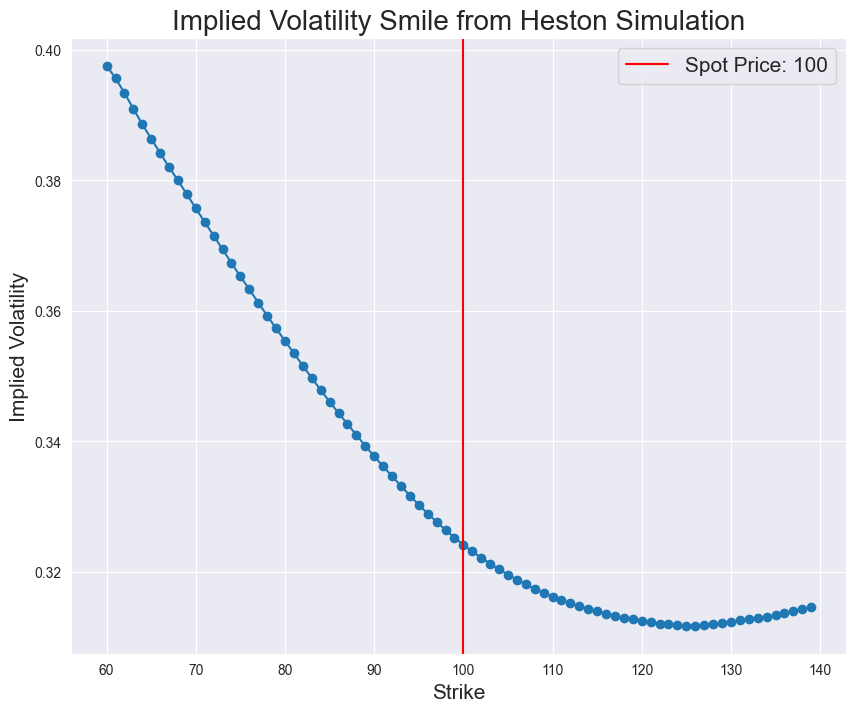

In [127]:
kappa = 5
theta = .45**2
xi = .8
v0 = 0.2**2
rho = -0.3
S0 = 100
t = 3/12
steps = 62
r = 0.04
n_sims = 100000
dt = t / steps
mu = 0

# Heston simulation


#initialize paths
paths = np.zeros((n_sims, steps + 1))
vols = np.zeros((n_sims, steps + 1))
paths[:, 0] = S0
vols[:, 0] = v0

for i in range(steps):
    #Create Random noise at each step (this can be vectorized before the look to make things faster)
    
    #N1 and Y are standard normals with correlation rho
    
    
    N1 = np.random.normal(0,1, size = n_sims)
    N2 = np.random.normal(0,1, size = n_sims)
    
    Y = rho*N1 + np.sqrt(1-rho**2)*N2

    vols[:, i+1] = np.abs(vols[:, i]+kappa*(theta - vols[:, i])*dt + xi*np.sqrt(vols[:, i]*dt)*N1)
    paths[:, i+1] = paths[:,i]*np.exp((mu+r-.5*vols[:,i])*dt + np.sqrt(vols[:,i]*dt)*Y)

    
    
    
# Option pricing
strikes = range(int(.6*S0), int(1.4*S0))
S_t = paths[:, -1]
call_dict = {K: np.mean(np.maximum(S_t - K, 0)) * np.exp(-r * t) for K in strikes}


# Compute implied vols
implied_vol = {K: implied_volatility_call(call_dict[K], S0, K, t, r) for K in strikes}

# Plot
plt.figure(figsize = (10,8))
plt.plot(list(implied_vol.keys()), list(implied_vol.values()), marker='o')
plt.xlabel("Strike", size = 15)
plt.ylabel("Implied Volatility", size = 15)
plt.title("Implied Volatility Smile from Heston Simulation", size = 20)
plt.grid(True)
plt.axvline(S0, label= f'Spot Price: {S0}', color = 'red')

plt.legend(fontsize = 15)
plt.show()

In [45]:
import numpy as np

def heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, mu=0, n_sims=1):
    """
    Simulation of stock path movements under the Heston stochastic volatility model.
    
    Parameters:
    - S0 (float): Initial stock price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - mu (float): Drift component (excess return above r)
    - n_sims (int): Number of simulated paths

    Returns:
    - paths (ndarray): Simulated stock price paths of shape (n_sims, n_steps + 1)
    """
    dt = t / n_steps
    N1 = np.random.normal(0, 1, size=(n_sims, n_steps))
    N2 = np.random.normal(0, 1, size=(n_sims, n_steps))
    Y = rho * N1 + np.sqrt(1 - rho**2) * N2

    paths = np.zeros((n_sims, n_steps + 1))
    vols = np.zeros((n_sims, n_steps + 1))
    paths[:, 0] = S0
    vols[:, 0] = v0

    for i in range(n_steps):
        vols[:, i + 1] = np.abs(vols[:, i] + kappa * (theta - vols[:, i]) * dt +
                                xi * np.sqrt(np.maximum(vols[:, i], 0) * dt) * N1[:, i])
        paths[:, i + 1] = paths[:, i] * np.exp((mu + r - 0.5 * vols[:, i]) * dt +
                                               np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])
    
    return paths


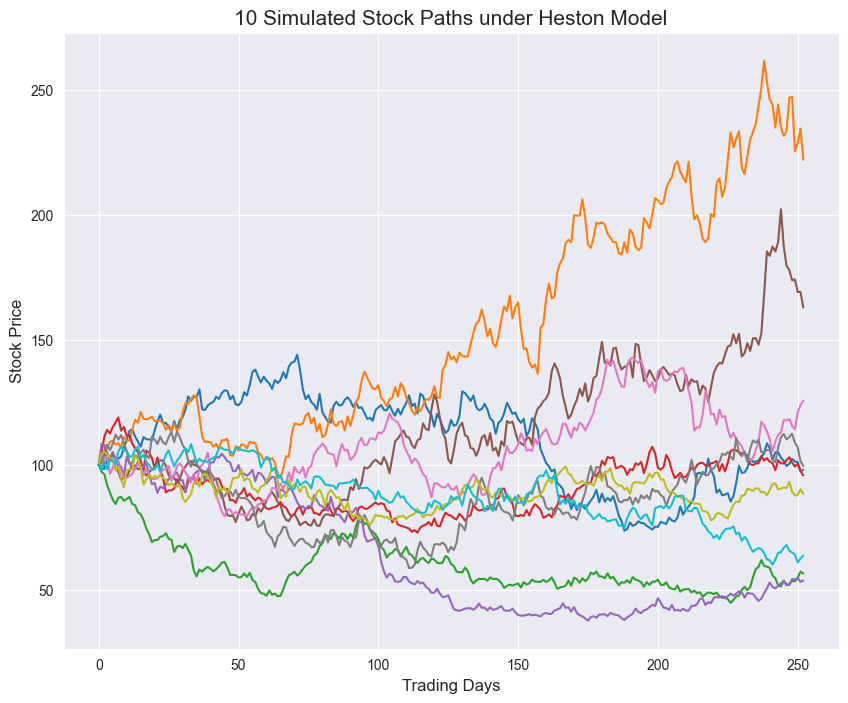

In [75]:
### Simulated stock paths under Heston model
kappa = 4
theta = .45**2
xi = .5
v0 = 0.4**2
rho = -0.05
S0 = 100
t = 1
n_steps = 252
r = 0.04
n_sims = 10
dt = t / steps
mu = .06


paths = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, mu, n_sims)


plt.figure(figsize = (10,8))

for path in paths:
    plt.plot(path)
    
plt.title(f'{n_sims} Simulated Stock Paths under Heston Model', size = 15)
plt.xlabel('Trading Days', size = 12)
plt.ylabel('Stock Price', size = 12)

plt.show()